# AG news text classification

## 1. First approach

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
Class Index    120000 non-null int64
Title          120000 non-null object
Description    120000 non-null object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
None


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Seems like there is no missing values in the dataset. Let's combine title and description into one feature for convenience.

In [2]:
df['summary'] = df['Title'] + ' ' + df['Description']
df.drop(['Title', 'Description'], axis=1, inplace=True)
df.head()

,Class Index,summary
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


Is there any blank strings in this new feature?

In [3]:
blanks = []
for idx,label,summary in df.itertuples():
    if type(summary)==str:
        if summary.isspace():
            blanks.append(i)
            
blanks

[]

Now we need to try some feature engineering. And chekc if it's working.

In [4]:
labels = {1:'World News', 2:'Sports News', 3:'Business News', 4:'Science-Technology News'}
df['label'] = df['Class Index'].map(labels)

df['num_of_words'] = df['summary'].apply(lambda x: len(x.split()))
df['num_of_chars'] = df['summary'].apply(lambda x: len(list(x)))
df.head()

,Class Index,summary,label,num_of_words,num_of_chars
0,3,Wall St. Bears Claw Back Into the Black (Reute...,Business News,21,144
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Business News,36,266
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business News,36,232
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Business News,36,256
4,3,"Oil prices soar to all-time record, posing new...",Business News,37,234


C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


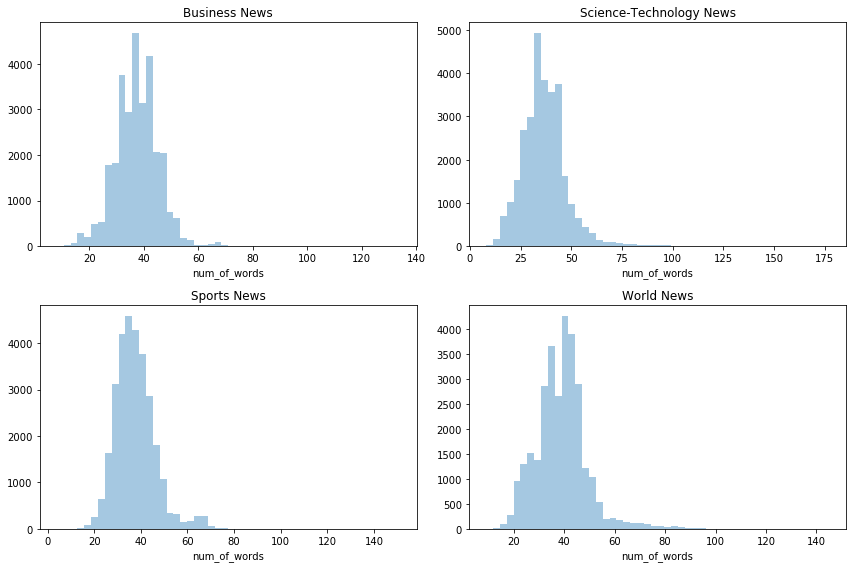

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = df['label'].unique()

plt.figure(figsize=(12,8))

for i in range(df['label'].nunique()):
    plt.subplot(2,2,i+1)
    label = unique_labels[i]
    df_temp = df.query('label == @label')
    sns.distplot(df_temp['num_of_words'], kde=False)
    plt.title(label)

plt.tight_layout()
plt.show()

Histograms look very similar, thus we, probably, won't need these features.

In [6]:
df.drop(['num_of_chars', 'num_of_words','label'], axis=1, inplace=True)
df.head()

,Class Index,summary
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.feature_extraction import text

text_clf_lsvc2 = Pipeline([('tfidf', TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS)),
                     ('clf', LinearSVC()),
])
text_clf_lsvc2.fit(df['summary'], df['Class Index'])

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterward...
                                                       'anything', 'anyway',
                                                       'anywhere', ...}),
                                 strip_accents=None, sublinear_tf=False,
                                

In [8]:
test_df = pd.read_csv('test.csv')
test_df['summary'] = test_df['Title'] + ' ' + test_df['Description']
test_df.drop(['Title', 'Description'], axis=1, inplace=True)
X_test = test_df['summary']
y_test = test_df['Class Index']

predictions = text_clf_lsvc2.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))

[[1717   54   78   51]
 [  19 1861   12    8]
 [  54   15 1684  147]
 [  49   10  124 1717]]


In [9]:
print(metrics.accuracy_score(y_test,predictions))

0.9182894736842105


In [10]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.89      0.89      0.89      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



## 2. Second approach

In [11]:
df = pd.read_csv('train.csv')
df['text'] = df['Title'] + ' ' + df['Description']
df.drop(['Title','Description'], axis=1, inplace=True)
df.head()

,Class Index,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


We need to define the max length of a sentence.

In [12]:
df['text'].apply(lambda x: len(x.split(' '))).max()

197

Time to load the pre-trained word vectors.

In [13]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


We need to apply Tokenizer to texts.

In [14]:
from keras.preprocessing.text import Tokenizer

texts = df['text'].values
targets = df['Class Index'].values

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Using TensorFlow backend.


Found 70337 unique tokens.


Transforming every sequence to the same length

In [15]:
from keras.preprocessing.sequence import pad_sequences

# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (120000, 200)


Creation of embedding matrix

In [16]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
      if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Creating RNN model and training it.

In [17]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM,Bidirectional, GlobalMaxPool1D


# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(df['Class Index'].nunique()+1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)


r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 96000 samples, validate on 24000 samples
Epoch 1/10
96000/96000 [==============================] - 180s 2ms/step - loss: 0.4373 - accuracy: 0.8648 - val_loss: 0.2918 - val_accuracy: 0.8992
Epoch 2/10
96000/96000 [==============================] - 182s 2ms/step - loss: 0.2881 - accuracy: 0.9026 - val_loss: 0.2697 - val_accuracy: 0.9045
Epoch 3/10
96000/96000 [==============================] - 183s 2ms/step - loss: 0.2654 - accuracy: 0.9098 - val_loss: 0.2558 - val_accuracy: 0.9089
Epoch 4/10
96000/96000 [==============================] - 184s 2ms/step - loss: 0.2515 - accuracy: 0.9143 - val_loss: 0.2574 - val_accuracy: 0.9069
Epoch 5/10
96000/96000 [==============================] - 183s 2ms/step - loss: 0.2400 - accuracy: 0.9174 - val_loss: 0.2529 - val_accuracy: 0.9085
Epoch 6/10
9

In [19]:
test = pd.read_csv('test.csv')
test['text'] = test['Title'] + ' ' + test['Description']
test.drop(['Title', 'Description'], axis=1, inplace=True)
test.head()

,Class Index,text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


In [20]:
from sklearn import metrics

data = test['text'].values
target = test['Class Index'].values
test_sequences = tokenizer.texts_to_sequences(data)
data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(data).argmax(axis=1)
df = pd.DataFrame({'true':target,'pred':pred})
print(metrics.accuracy_score(df['true'],df['pred']))

0.9119736842105263
